## Setup

In [1]:
import numpy as np
import torch

import torch.multiprocessing as mp

import os, sys

sys.path.append("/home/user/MLP/")

from backend.cli import base_args, build_other_grabs

from backend.job_iterator import main as run_job_iterator
from backend.utils import ensure_torch

import os, sys

In [2]:
## All args should be set here

args = base_args() #default args

# Set any args that we want to differ
args.ONLINE = False
args.ONLYTHRESHOLDS = True
args.N_TRAIN=4000
args.N_TEST=1000
args.N_TOT = args.N_TEST+args.N_TRAIN
args.CLASSES = [[0], [6]]
args.NORMALIZED = True
args.NUM_TRIALS = 2
args.LR = 1e-1
args.MAX_ITER = 1e3
args.N_SAMPLES = [16]
args.GAMMA = [0.1, 1, 10]
args.other_model_grabs = {"ENTK_trace": "empirical_ntk_trace"}
args.other_model_gram = {"ENTK_trace": {"call_with_model": True}}

iterators = [args.N_SAMPLES, range(args.NUM_TRIALS), args.GAMMA]
iterator_names = ["ntrain", "trial", "GAMMA"]

## Code execution

In [3]:
## Dataset
from ImageData import ImageData, preprocess
PIXEL_NORMALIZED =  False # Don't normalize pixels, normalize samples
classes = args.CLASSES if args.datasethps is not None else args.datasethps.get('classes', None)
normalized = args.NORMALIZED if args.datasethps is not None else args.datasethps.get('normalized', True)

if classes is not None:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=len(classes)!=2)
else:
	imdata = ImageData('cifar10', "../data", classes=classes, onehot=False)
X_train, y_train = imdata.get_dataset(args.N_TRAIN, get='train')
X_train = preprocess(X_train, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_test, y_test = imdata.get_dataset(args.N_TEST, get='test')
X_test = preprocess(X_test, center=True, greyscale=True, normalize=PIXEL_NORMALIZED)
X_train, y_train, X_test, y_test = map(ensure_torch, (X_train, y_train, X_test, y_test))
y_train = y_train.squeeze()
y_test = y_test.squeeze()
X_train, y_train, X_test, y_test = [t/torch.linalg.norm(t) for t in (X_train, y_train, X_test, y_test)] if normalized else (X_train, y_train, X_test, y_test)
if normalized:
	X_train *= args.N_TRAIN**(0.5); X_test *= args.N_TEST**(0.5)
	y_train *= args.N_TRAIN**(0.5); y_test *= args.N_TEST**(0.5)
X_full = torch.cat((X_train, X_test), dim=0)
y_full = torch.cat((y_train, y_test), dim=0)
data_eigvals = torch.linalg.svdvals(X_full)**2
data_eigvals /= data_eigvals.sum()

U, lambdas, Vt = torch.linalg.svd(X_full, full_matrices=False)
dim = X_full.shape[1]

def general_batch_fn(X_total, y_total, X=None, y=None, bsz=128,
                     gen=None, **kwargs):
    def batch_fn(step: int, X=X, y=y):
        if (X is not None) and (y is not None):
            X = ensure_torch(X)
            y = ensure_torch(y)
            return X, y
        with torch.no_grad():
            N_total = X_total.shape[0]
            indices = torch.randint(0, N_total, (bsz,), generator=gen, device=gen.device)
            X_batch = ensure_torch(X_total.to(gen.device)[indices])
            y_batch = ensure_torch(y_total.to(gen.device)[indices])
            return X_batch, y_batch
    return batch_fn

bfn_config = dict(base_bfn=general_batch_fn, X_total = X_full, y_total = y_full, bfn_name="general_batch_fn")
del X_full, y_full

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
global_config = dict(DEPTH=args.DEPTH, WIDTH=args.WIDTH, LR=args.LR, GAMMA=args.GAMMA,
	EMA_SMOOTHER=args.EMA_SMOOTHER, MAX_ITER=args.MAX_ITER,
	LOSS_CHECKPOINTS=args.LOSS_CHECKPOINTS, N_TEST=args.N_TEST,
	SEED=args.SEED, ONLYTHRESHOLDS=args.ONLYTHRESHOLDS, DIM=dim,
	ONLINE=args.ONLINE, VERBOSE=args.VERBOSE
	)

grabs = build_other_grabs(args.other_model_grabs, per_alias_kwargs=args.other_model_kwargs,)
global_config.update({"otherreturns": grabs})

In [5]:
# mp.set_start_method("spawn", force=True)

result = run_job_iterator(iterators, iterator_names, global_config, bfn_config=bfn_config)
torch.cuda.empty_cache()

Runs: 100%|██████████| 6/6 [02:30<00:00, 25.13s/it, train 0.21 | test 0.248 | timekey [0 0] | ntrain=16 | trial=1 | GAMMA=10]  


## Analyzing results

In [6]:
result['extras']

{'ENTK_trace': {'var_names': ['ntrain', 'trial', 'GAMMA'],
  'config2outcome': {(16, 0, '0.1'): 6.5369735,
   (16, 0, '1'): 7.6598415,
   (16, 0, '10'): 1.9024937,
   (16, 1, '0.1'): 6.5369735,
   (16, 1, '1'): 7.6598415,
   (16, 1, '10'): 1.9024937},
  'outcome_shape': ()}}

In [7]:
from ExptTrace import ExptTrace
et_losses = ExptTrace.deserialize(result['losses'])
et_entk_trace = ExptTrace.deserialize(result['extras']['ENTK_trace'])

In [8]:
et_entk_trace, et_entk_trace[:, :, :], et_losses[:, :, :]

(<ExptTrace.ExptTrace at 0x7f67e0bd3ad0>,
 array([[[6.53697348, 7.65984154, 1.90249372],
         [6.53697348, 7.65984154, 1.90249372]]]),
 array([[[0.74421521, 0.22635008, 0.21016213],
         [0.74421521, 0.22635008, 0.21016213]]]))

Text(0, 0.5, 'Final Loss')

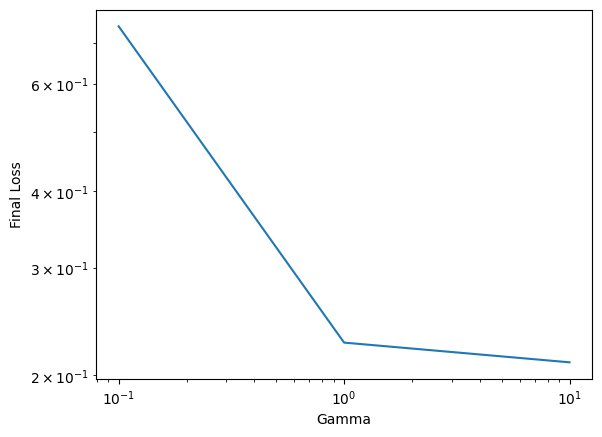

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.unique(np.array(result['jobs'])[:, -1]), et_losses[:, :, :].mean(axis=1).flatten())
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Gamma")
plt.ylabel("Final Loss")